In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score, accuracy_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import random_projection
from sklearn.mixture import GaussianMixture

# Load the dataset
wine_dataset = load_wine()

# Access the feature names
feature_names = wine_dataset.feature_names

# Access the data and target
data = wine_dataset.data
target = wine_dataset.target

# Convert data and target to a Pandas DataFrame
wine_df = pd.DataFrame(data, columns=feature_names)
wine_df['target'] = target

np.random.seed(42)

print(wine_df.info())
print(wine_df.shape)

# Normalize features for better performance
min_max_scaler = MinMaxScaler()
wineX = min_max_scaler.fit_transform(wine_df.drop("target", axis=1).values)
wineY = wine_df["target"].values

# Perform a stratified split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(wineX, wineY, test_size=0.2, stratify=wineY, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

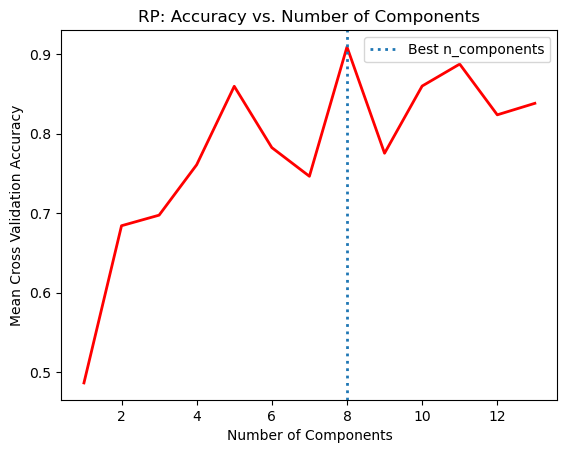

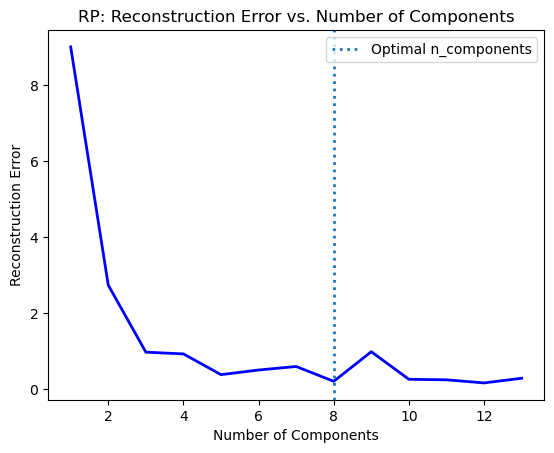

Reconstruction error with the chosen number of components (8): 0.19769235917086506


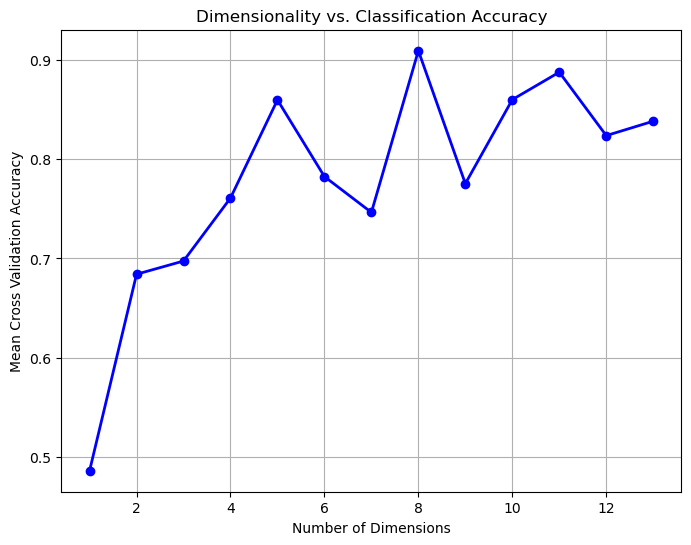

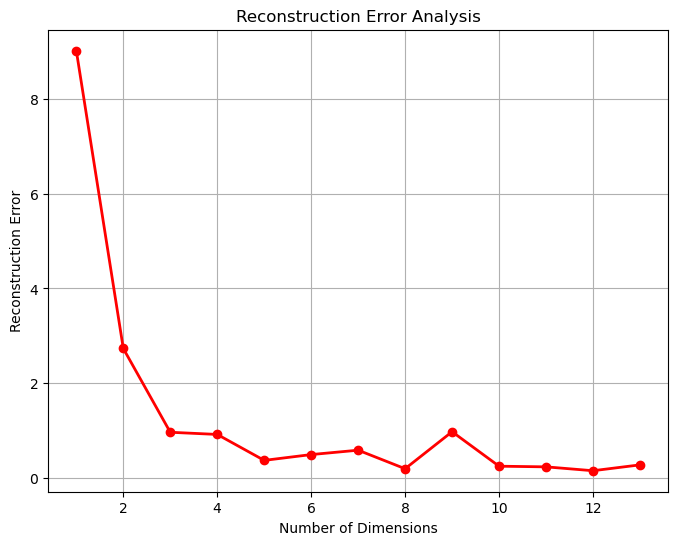

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

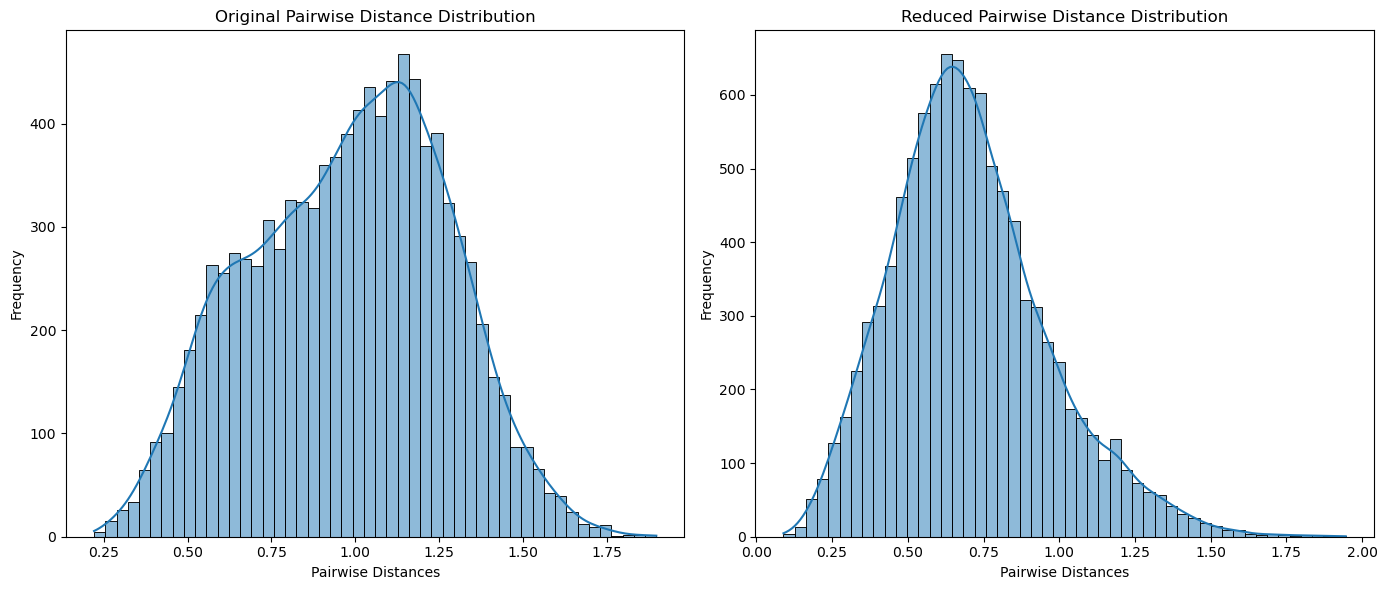

In [4]:
# Set up the Random Projection transformer and the Decision Tree classifier
decisiontree = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)
rp = random_projection.GaussianRandomProjection()

# Create a pipeline that first applies RP and then fits a Decision Tree
pipe = Pipeline(steps=[('rp', rp), ('decisionTree', decisiontree)])

# Perform a grid search to find the best number of components for RP
n_components_range = range(1, X_train.shape[1]+1)
gridSearch = GridSearchCV(pipe, dict(rp__n_components=n_components_range), cv=3)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_

# Plot the mean cross-validation accuracy as a function of the number of components
plt.figure()
plt.plot(n_components_range, results['mean_test_score'], 'r-', linewidth=2)
plt.axvline(gridSearch.best_estimator_.named_steps['rp'].n_components, linestyle=':', label='Best n_components', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Mean Cross Validation Accuracy')
plt.title('RP: Accuracy vs. Number of Components')
plt.legend(loc='best')
plt.show()

# Apply the optimal number of components for RP to the training and testing sets
optimal_rp = gridSearch.best_estimator_.named_steps['rp']
X_train_rp = optimal_rp.transform(X_train)
X_test_rp = optimal_rp.transform(X_test)

# Function to calculate reconstruction error
def reconstruction_error(rp, X_original, X_transformed):
    X_projected = X_transformed.dot(rp.components_) + np.mean(X_original, axis=0)
    return np.mean(np.square(X_original - X_projected))

# Calculate reconstruction errors for each number of components
reconstruction_errors = []
for comp in n_components_range:
    rp = random_projection.GaussianRandomProjection(n_components=comp)
    X_transformed = rp.fit_transform(X_train)
    error = reconstruction_error(rp, X_train, X_transformed)
    reconstruction_errors.append(error)
    if comp == optimal_rp.n_components:
        chosen_error = error

# Plot the reconstruction error
plt.figure()
plt.plot(n_components_range, reconstruction_errors, 'b-', linewidth=2)
plt.axvline(optimal_rp.n_components, linestyle=':', label='Optimal n_components', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('RP: Reconstruction Error vs. Number of Components')
plt.legend(loc='best')
plt.show()

print(f"Reconstruction error with the chosen number of components ({optimal_rp.n_components}): {chosen_error}")

# Use the previous grid search results to plot dimensionality vs. accuracy
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, results['mean_test_score'], 'o-', linewidth=2, color='blue')
plt.title('Dimensionality vs. Classification Accuracy')
plt.xlabel('Number of Dimensions')
plt.ylabel('Mean Cross Validation Accuracy')
plt.grid(True)
plt.show()

# Plot the reconstruction error that you calculated earlier
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, reconstruction_errors, 'o-', linewidth=2, color='red')
plt.title('Reconstruction Error Analysis')
plt.xlabel('Number of Dimensions')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

# Compute pairwise distances for the original and reduced datasets
from scipy.spatial.distance import pdist, squareform

original_pairwise_dist = pdist(X_train, 'euclidean')
reduced_pairwise_dist = pdist(X_train_rp, 'euclidean')

# Plot the distributions of the pairwise distances
plt.figure(figsize=(14, 6))

# Original
plt.subplot(1, 2, 1)
sns.histplot(original_pairwise_dist, bins=50, kde=True)
plt.title('Original Pairwise Distance Distribution')
plt.xlabel('Pairwise Distances')
plt.ylabel('Frequency')

# Reduced
plt.subplot(1, 2, 2)
sns.histplot(reduced_pairwise_dist, bins=50, kde=True)
plt.title('Reduced Pairwise Distance Distribution')
plt.xlabel('Pairwise Distances')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [5]:
#EM clustering after RP

Silhouette Score on training data: 0.17
Silhouette Score on testing data: 0.20
Homogeneity Score on training data: 0.60
Homogeneity Score on testing data: 0.68


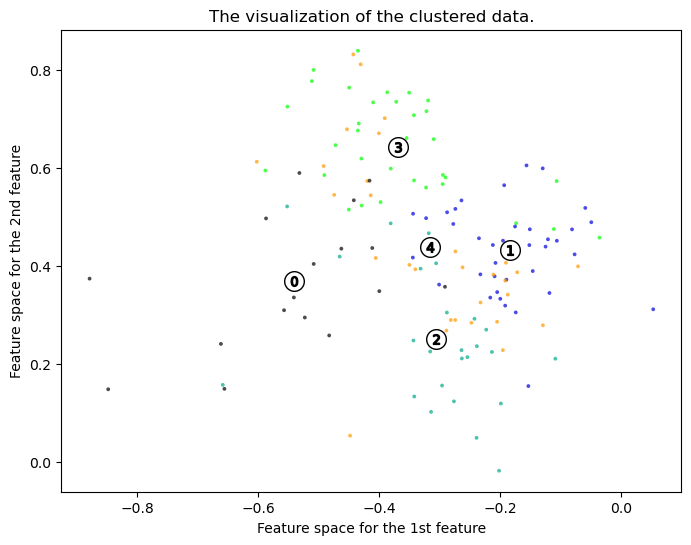

In [6]:
# Since you have found that the optimal number of clusters is 5, we will use this for our GMM
optimal_clusters = 5

# Initialize Gaussian Mixture Model with the number of components you found to be optimal
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)

# Fit the model with the data transformed by Random Projection
gmm.fit(X_train_rp)

# Predict the cluster labels
train_labels = gmm.predict(X_train_rp)
test_labels = gmm.predict(X_test_rp)

# Evaluate the clustering performance using silhouette score
train_silhouette = silhouette_score(X_train_rp, train_labels)
test_silhouette = silhouette_score(X_test_rp, test_labels)

print(f"Silhouette Score on training data: {train_silhouette:.2f}")
print(f"Silhouette Score on testing data: {test_silhouette:.2f}")

# You might also want to check the homogeneity of the clusters
train_homogeneity = homogeneity_score(y_train, train_labels)
test_homogeneity = homogeneity_score(y_test, test_labels)

print(f"Homogeneity Score on training data: {train_homogeneity:.2f}")
print(f"Homogeneity Score on testing data: {test_homogeneity:.2f}")

# Plotting the clusters
plt.figure(figsize=(8, 6))
colors = cm.nipy_spectral(train_labels.astype(float) / optimal_clusters)
plt.scatter(X_train_rp[:, 0], X_train_rp[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title("The visualization of the clustered data.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")

plt.show()

In [7]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# ARI
train_ari = adjusted_rand_score(y_train, train_labels)
test_ari = adjusted_rand_score(y_test, test_labels)

# NMI
train_nmi = normalized_mutual_info_score(y_train, train_labels)
test_nmi = normalized_mutual_info_score(y_test, test_labels)

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_train_rp, train_labels)

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X_train_rp, train_labels)

print(f"Adjusted Rand Index on training data: {train_ari:.2f}")
print(f"Adjusted Rand Index on testing data: {test_ari:.2f}")
print(f"Normalized Mutual Information on training data: {train_nmi:.2f}")
print(f"Normalized Mutual Information on testing data: {test_nmi:.2f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")

Adjusted Rand Index on training data: 0.41
Adjusted Rand Index on testing data: 0.51
Normalized Mutual Information on training data: 0.49
Normalized Mutual Information on testing data: 0.60
Calinski-Harabasz Index: 32.74
Davies-Bouldin Index: 1.62


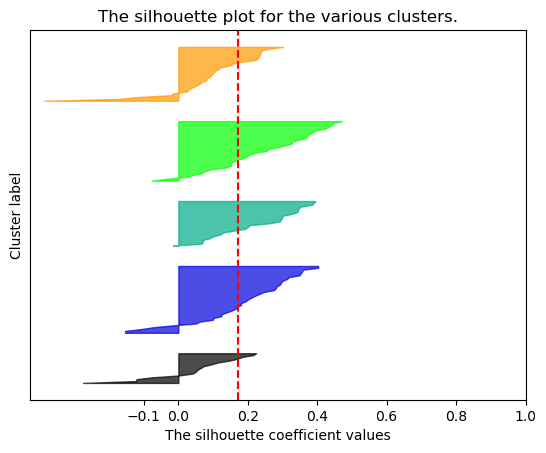

In [8]:
from sklearn.metrics import silhouette_samples

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_train_rp, train_labels)

fig, ax1 = plt.subplots(1, 1)
y_lower = 10
for i in range(optimal_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[train_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / optimal_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=train_silhouette, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


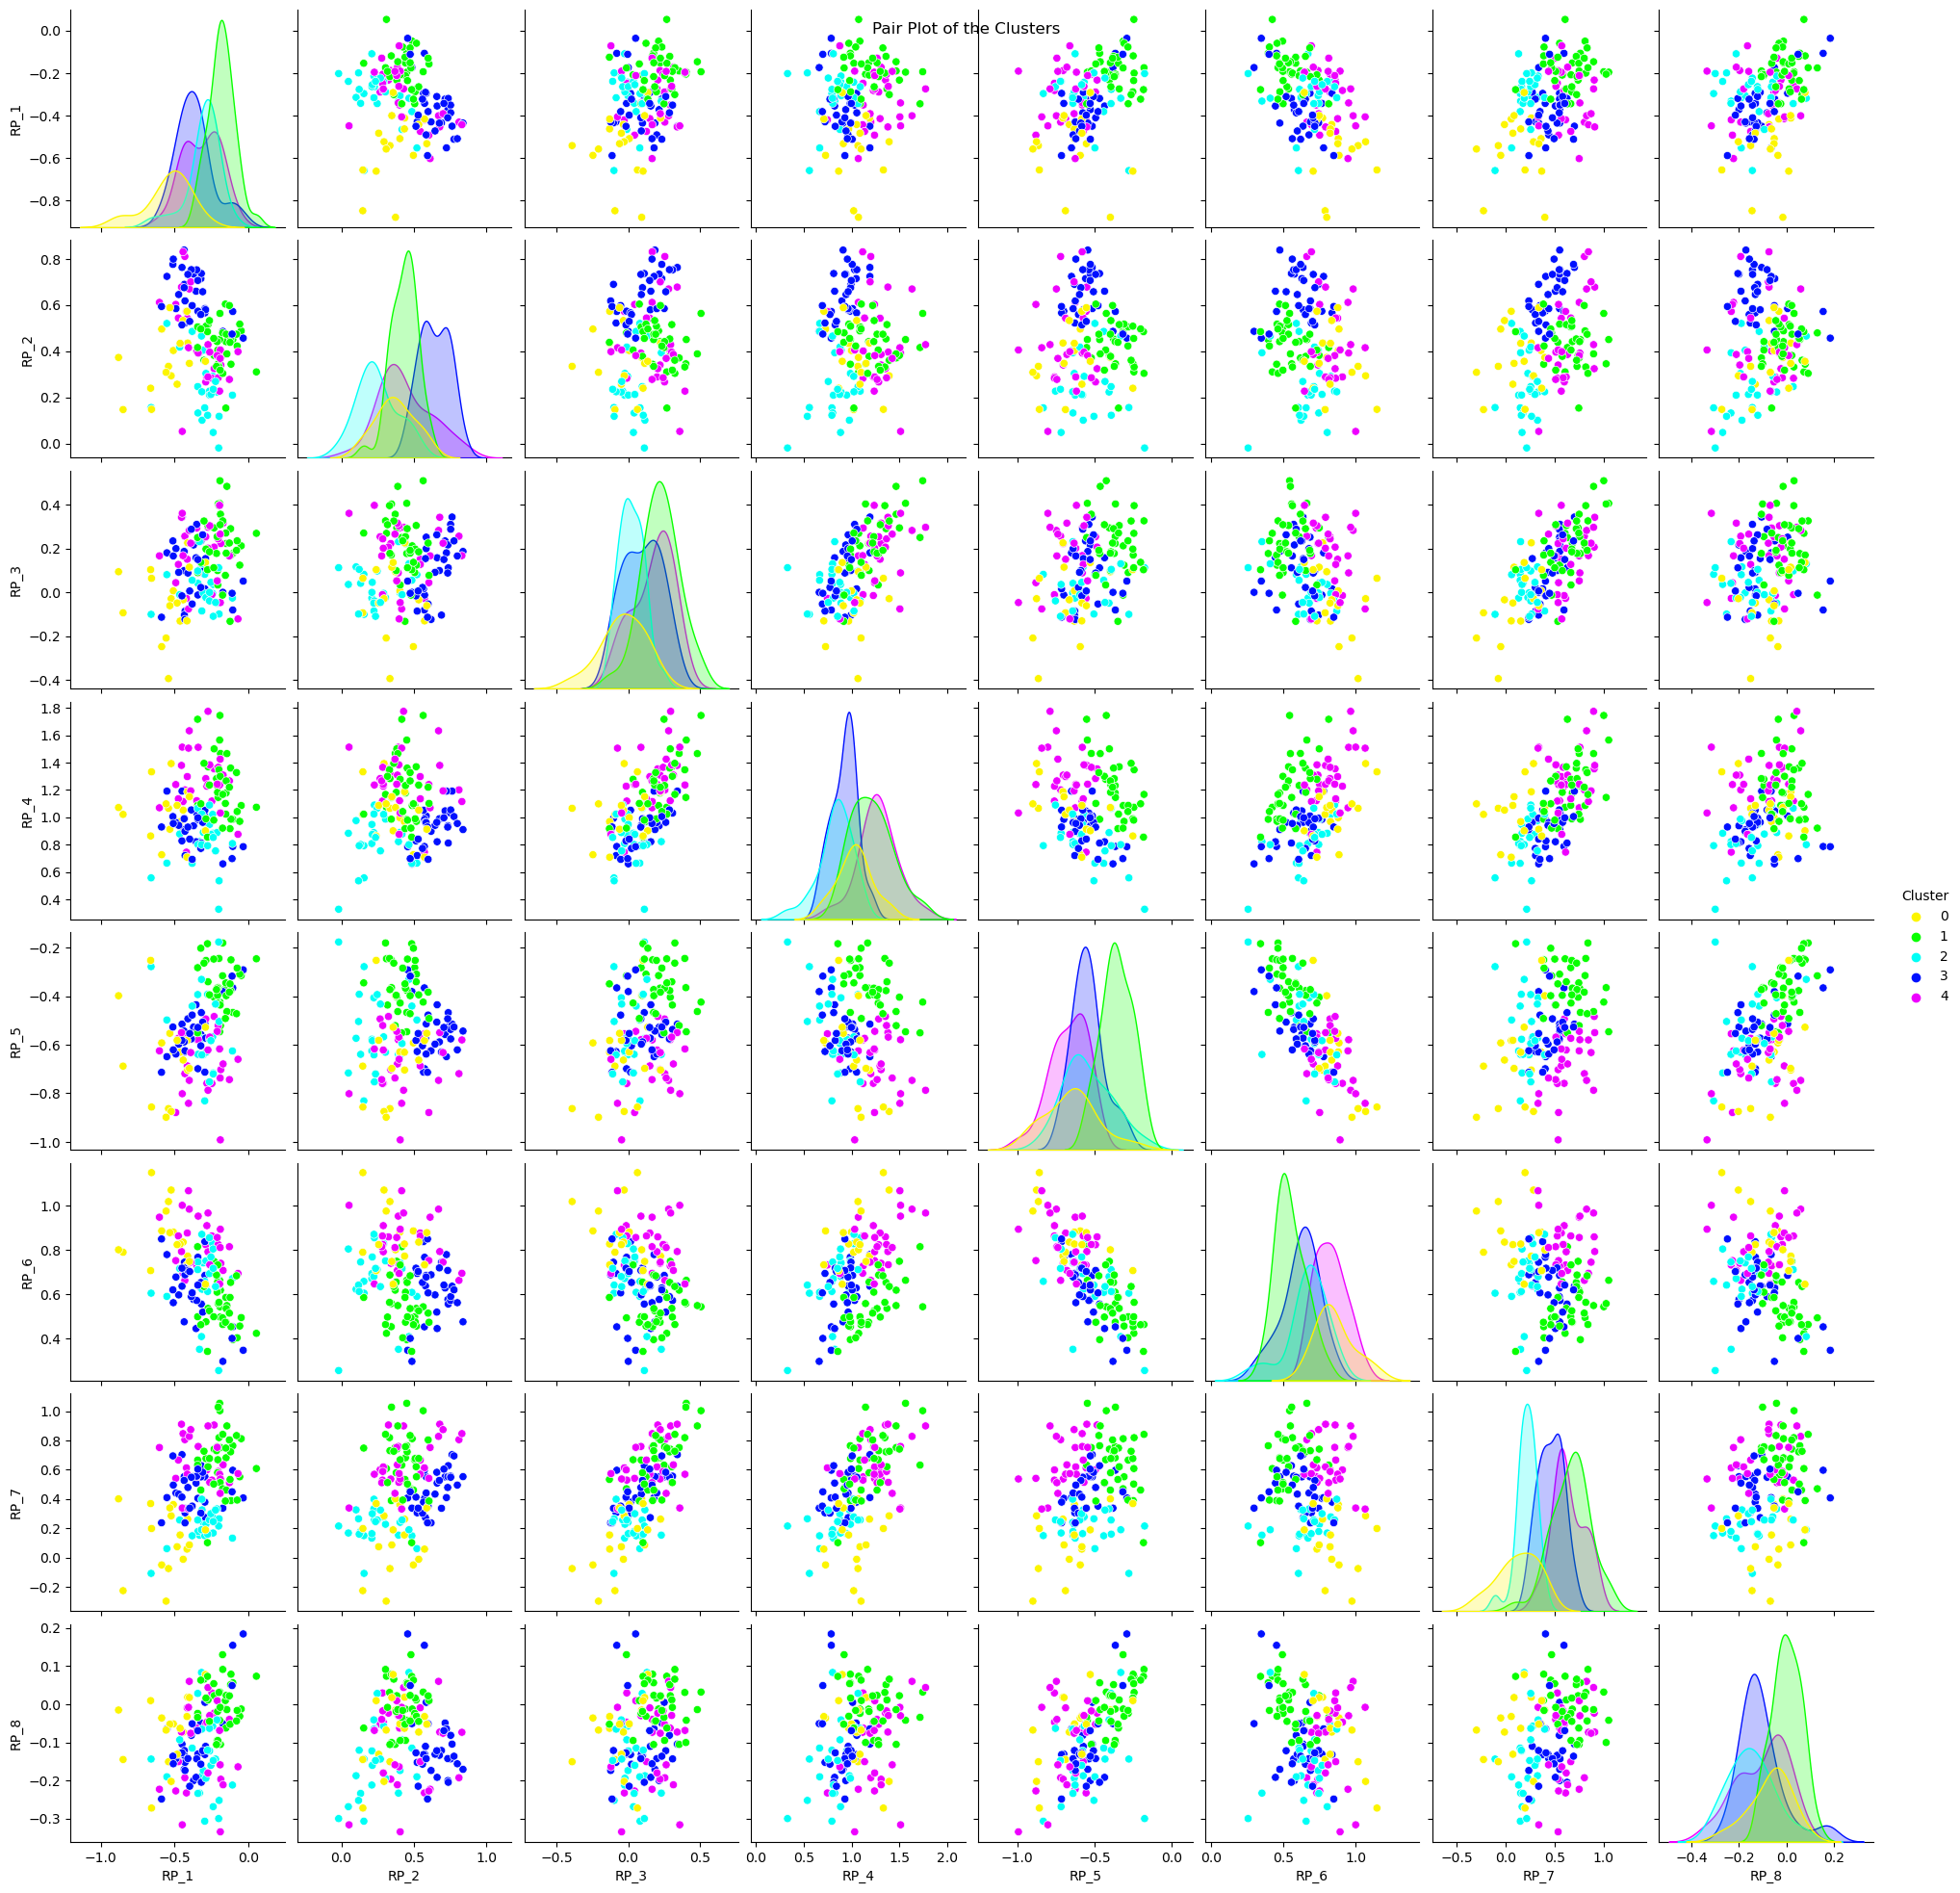

In [9]:
import seaborn as sns

# Convert the data to a DataFrame for sns pairplot
rp_df = pd.DataFrame(X_train_rp, columns=[f'RP_{i+1}' for i in range(X_train_rp.shape[1])])
rp_df['Cluster'] = train_labels

# Pairplot
sns.pairplot(rp_df, hue='Cluster', palette=sns.color_palette("hsv", optimal_clusters))
plt.suptitle("Pair Plot of the Clusters", verticalalignment='top')
plt.show()


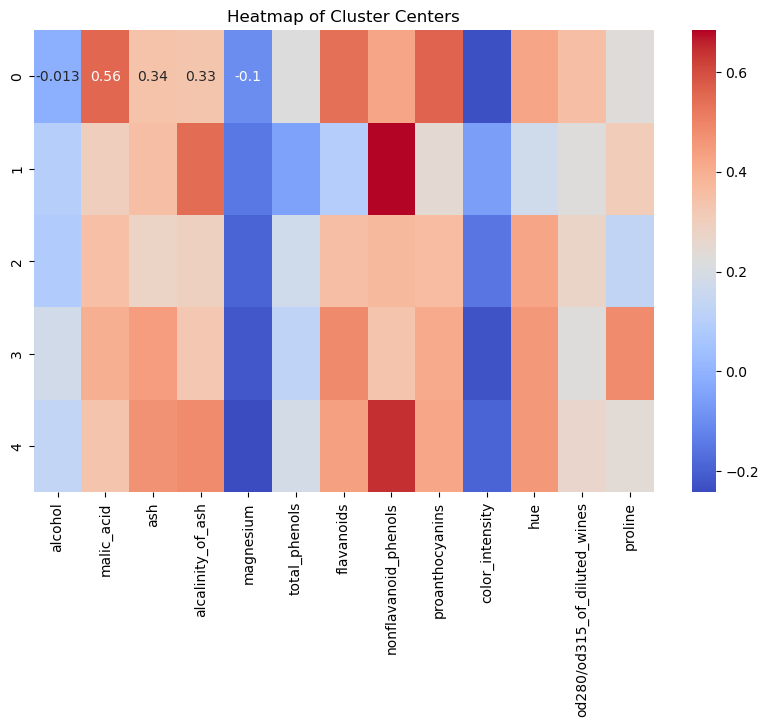

In [10]:
# Calculate the cluster centers in the original feature space
rp_inverse = optimal_rp.inverse_transform(gmm.means_)
cluster_center_df = pd.DataFrame(rp_inverse, columns=feature_names)

# Create a heatmap of the cluster centers
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_center_df, annot=True, cmap='coolwarm')
plt.title('Heatmap of Cluster Centers')
plt.show()

In [11]:
from scipy.stats import mode

# Map each cluster label to the true labels using mode
labels_true = np.zeros_like(train_labels)
for i in range(optimal_clusters):
    mask = (train_labels == i)
    labels_true[mask] = mode(y_train[mask])[0]

accuracy = np.sum(labels_true == y_train) / y_train.shape[0]
print(f'Accuracy (with label mapping): {accuracy:.2f}')

Accuracy (with label mapping): 0.82


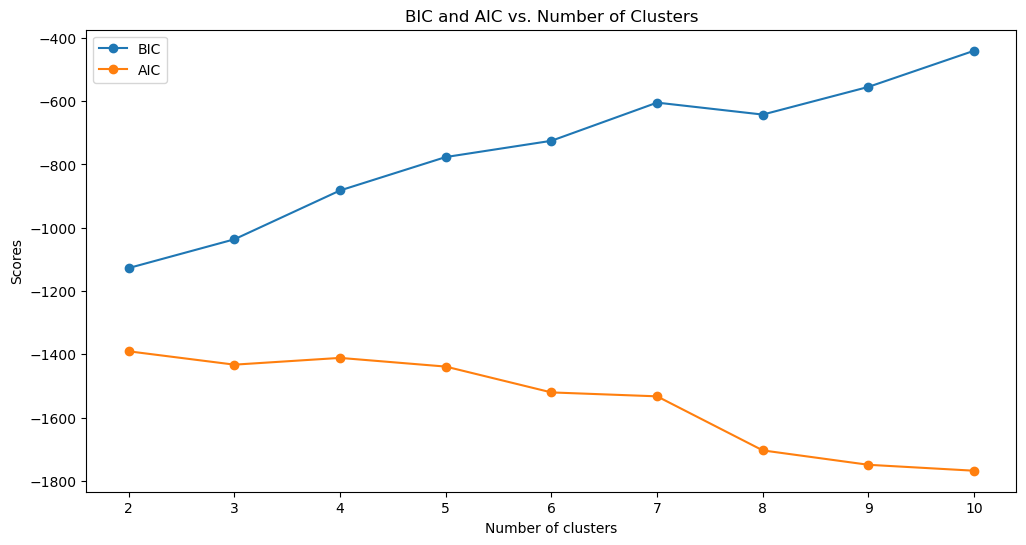

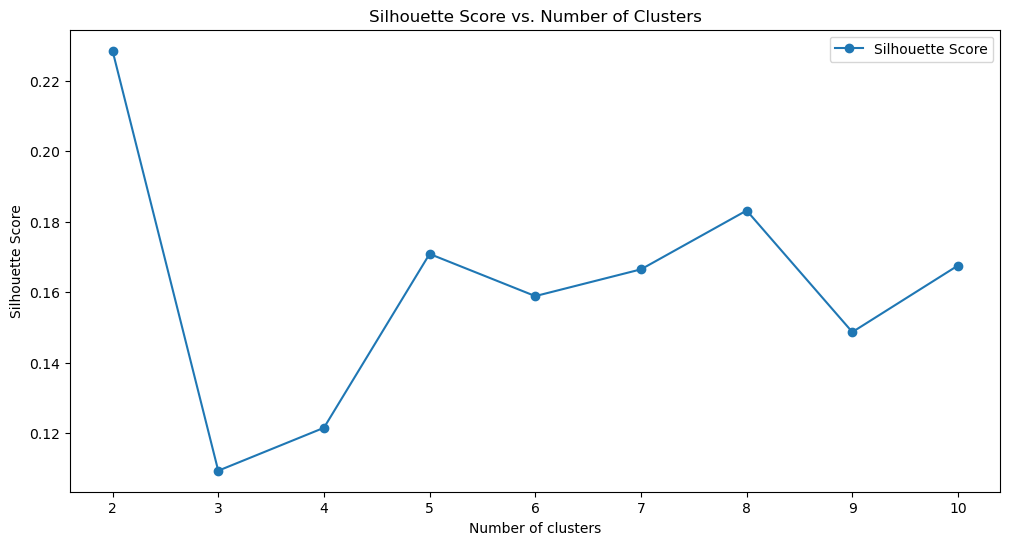

In [27]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

# Assuming X_train_rp is your dataset after applying RP with the optimal number of components

# Define the range of clusters to try
n_clusters_range = range(2, 11)  # For example, from 2 to 10 clusters
bics = []
aics = []
silhouette_scores = []

# Compute BIC, AIC, and Silhouette for each number of clusters
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_train_rp)
    labels = gmm.predict(X_train_rp)
    
    # Append BIC and AIC
    bics.append(gmm.bic(X_train_rp))
    aics.append(gmm.aic(X_train_rp))
    
    # Compute the average silhouette score and append it
    silhouette_avg = silhouette_score(X_train_rp, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting BIC and AIC
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, bics, label='BIC', marker='o')
plt.plot(n_clusters_range, aics, label='AIC', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.legend()
plt.title('BIC and AIC vs. Number of Clusters')
plt.show()

# Plotting Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, silhouette_scores, label='Silhouette Score', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

# Define the range of clusters to try
n_clusters_range = range(2, 11)  # For example, from 2 to 10 clusters
bics = []
aics = []
silhouette_scores = []

# Compute BIC, AIC, and Silhouette for each number of clusters
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_train_rp)
    labels = gmm.predict(X_train_rp)
    
    # Append BIC and AIC
    bics.append(gmm.bic(X_train_rp))
    aics.append(gmm.aic(X_train_rp))
    
    # Compute the average silhouette score and append it
    silhouette_avg = silhouette_score(X_train_rp, labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters based on BIC, AIC, and Silhouette Score
optimal_n_clusters_bic = n_clusters_range[np.argmin(bics)]
optimal_n_clusters_aic = n_clusters_range[np.argmin(aics)]
optimal_n_clusters_silhouette = n_clusters_range[np.argmax(silhouette_scores)]

# Print the optimal number of clusters for each criterion
print(f"Optimal number of clusters according to BIC: {optimal_n_clusters_bic}")
print(f"Optimal number of clusters according to AIC: {optimal_n_clusters_aic}")
print(f"Optimal number of clusters according to Silhouette Score: {optimal_n_clusters_silhouette}")

Optimal number of clusters according to BIC: 2
Optimal number of clusters according to AIC: 10
Optimal number of clusters according to Silhouette Score: 2


In [12]:
# K-Means

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

Sum of Squared Errors (SSE): 23.083879487126726


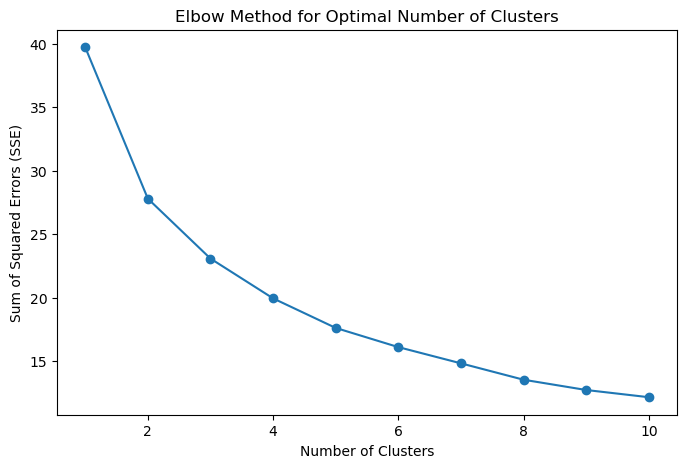

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


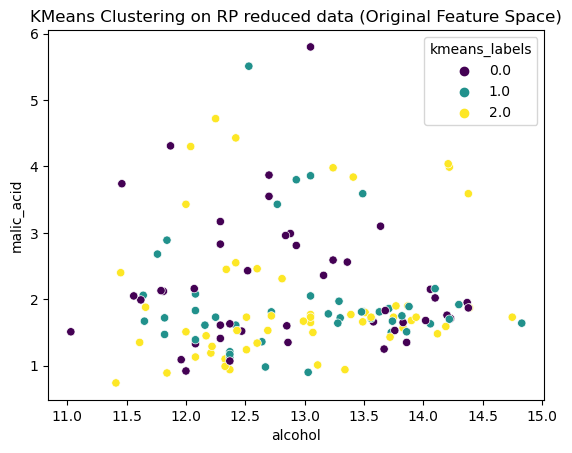

In [13]:
from sklearn.cluster import KMeans

# Since we have already reduced X_train to the optimal number of components, we can use X_train_rp directly

# Apply KMeans clustering to the reduced data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_rp)

# The labels of the clusters
kmeans_labels = kmeans.labels_

# Compute the sum of squared distances (SSE) of samples to their closest cluster center
sse = kmeans.inertia_

print(f"Sum of Squared Errors (SSE): {sse}")

# Visualize the SSE as a function of the number of clusters
sse_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_rp)
    sse_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse_values, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Assign the labels back to the original dataframe for visualization in the original feature space
# Note that this is only for visualization purposes and may not reflect actual separations in the reduced space
wine_df['kmeans_labels'] = np.nan
wine_df.loc[:len(kmeans_labels)-1, 'kmeans_labels'] = kmeans_labels

# Now you can plot these labels against any two original features for visualization
sns.scatterplot(data=wine_df, x='alcohol', y='malic_acid', hue='kmeans_labels', palette='viridis')
plt.title('KMeans Clustering on RP reduced data (Original Feature Space)')
plt.show()

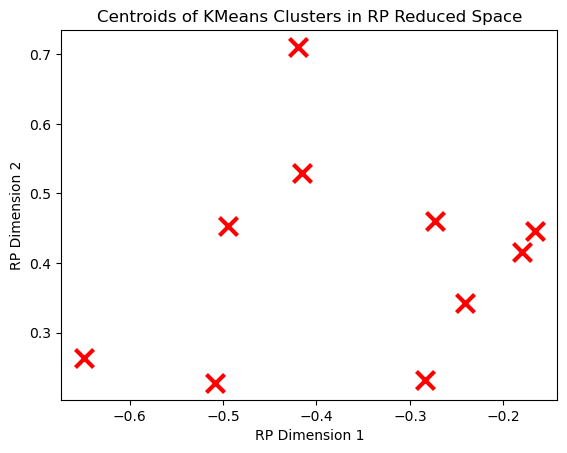

In [14]:
# Plot the centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Centroids of KMeans Clusters in RP Reduced Space')
plt.xlabel('RP Dimension 1')
plt.ylabel('RP Dimension 2')
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

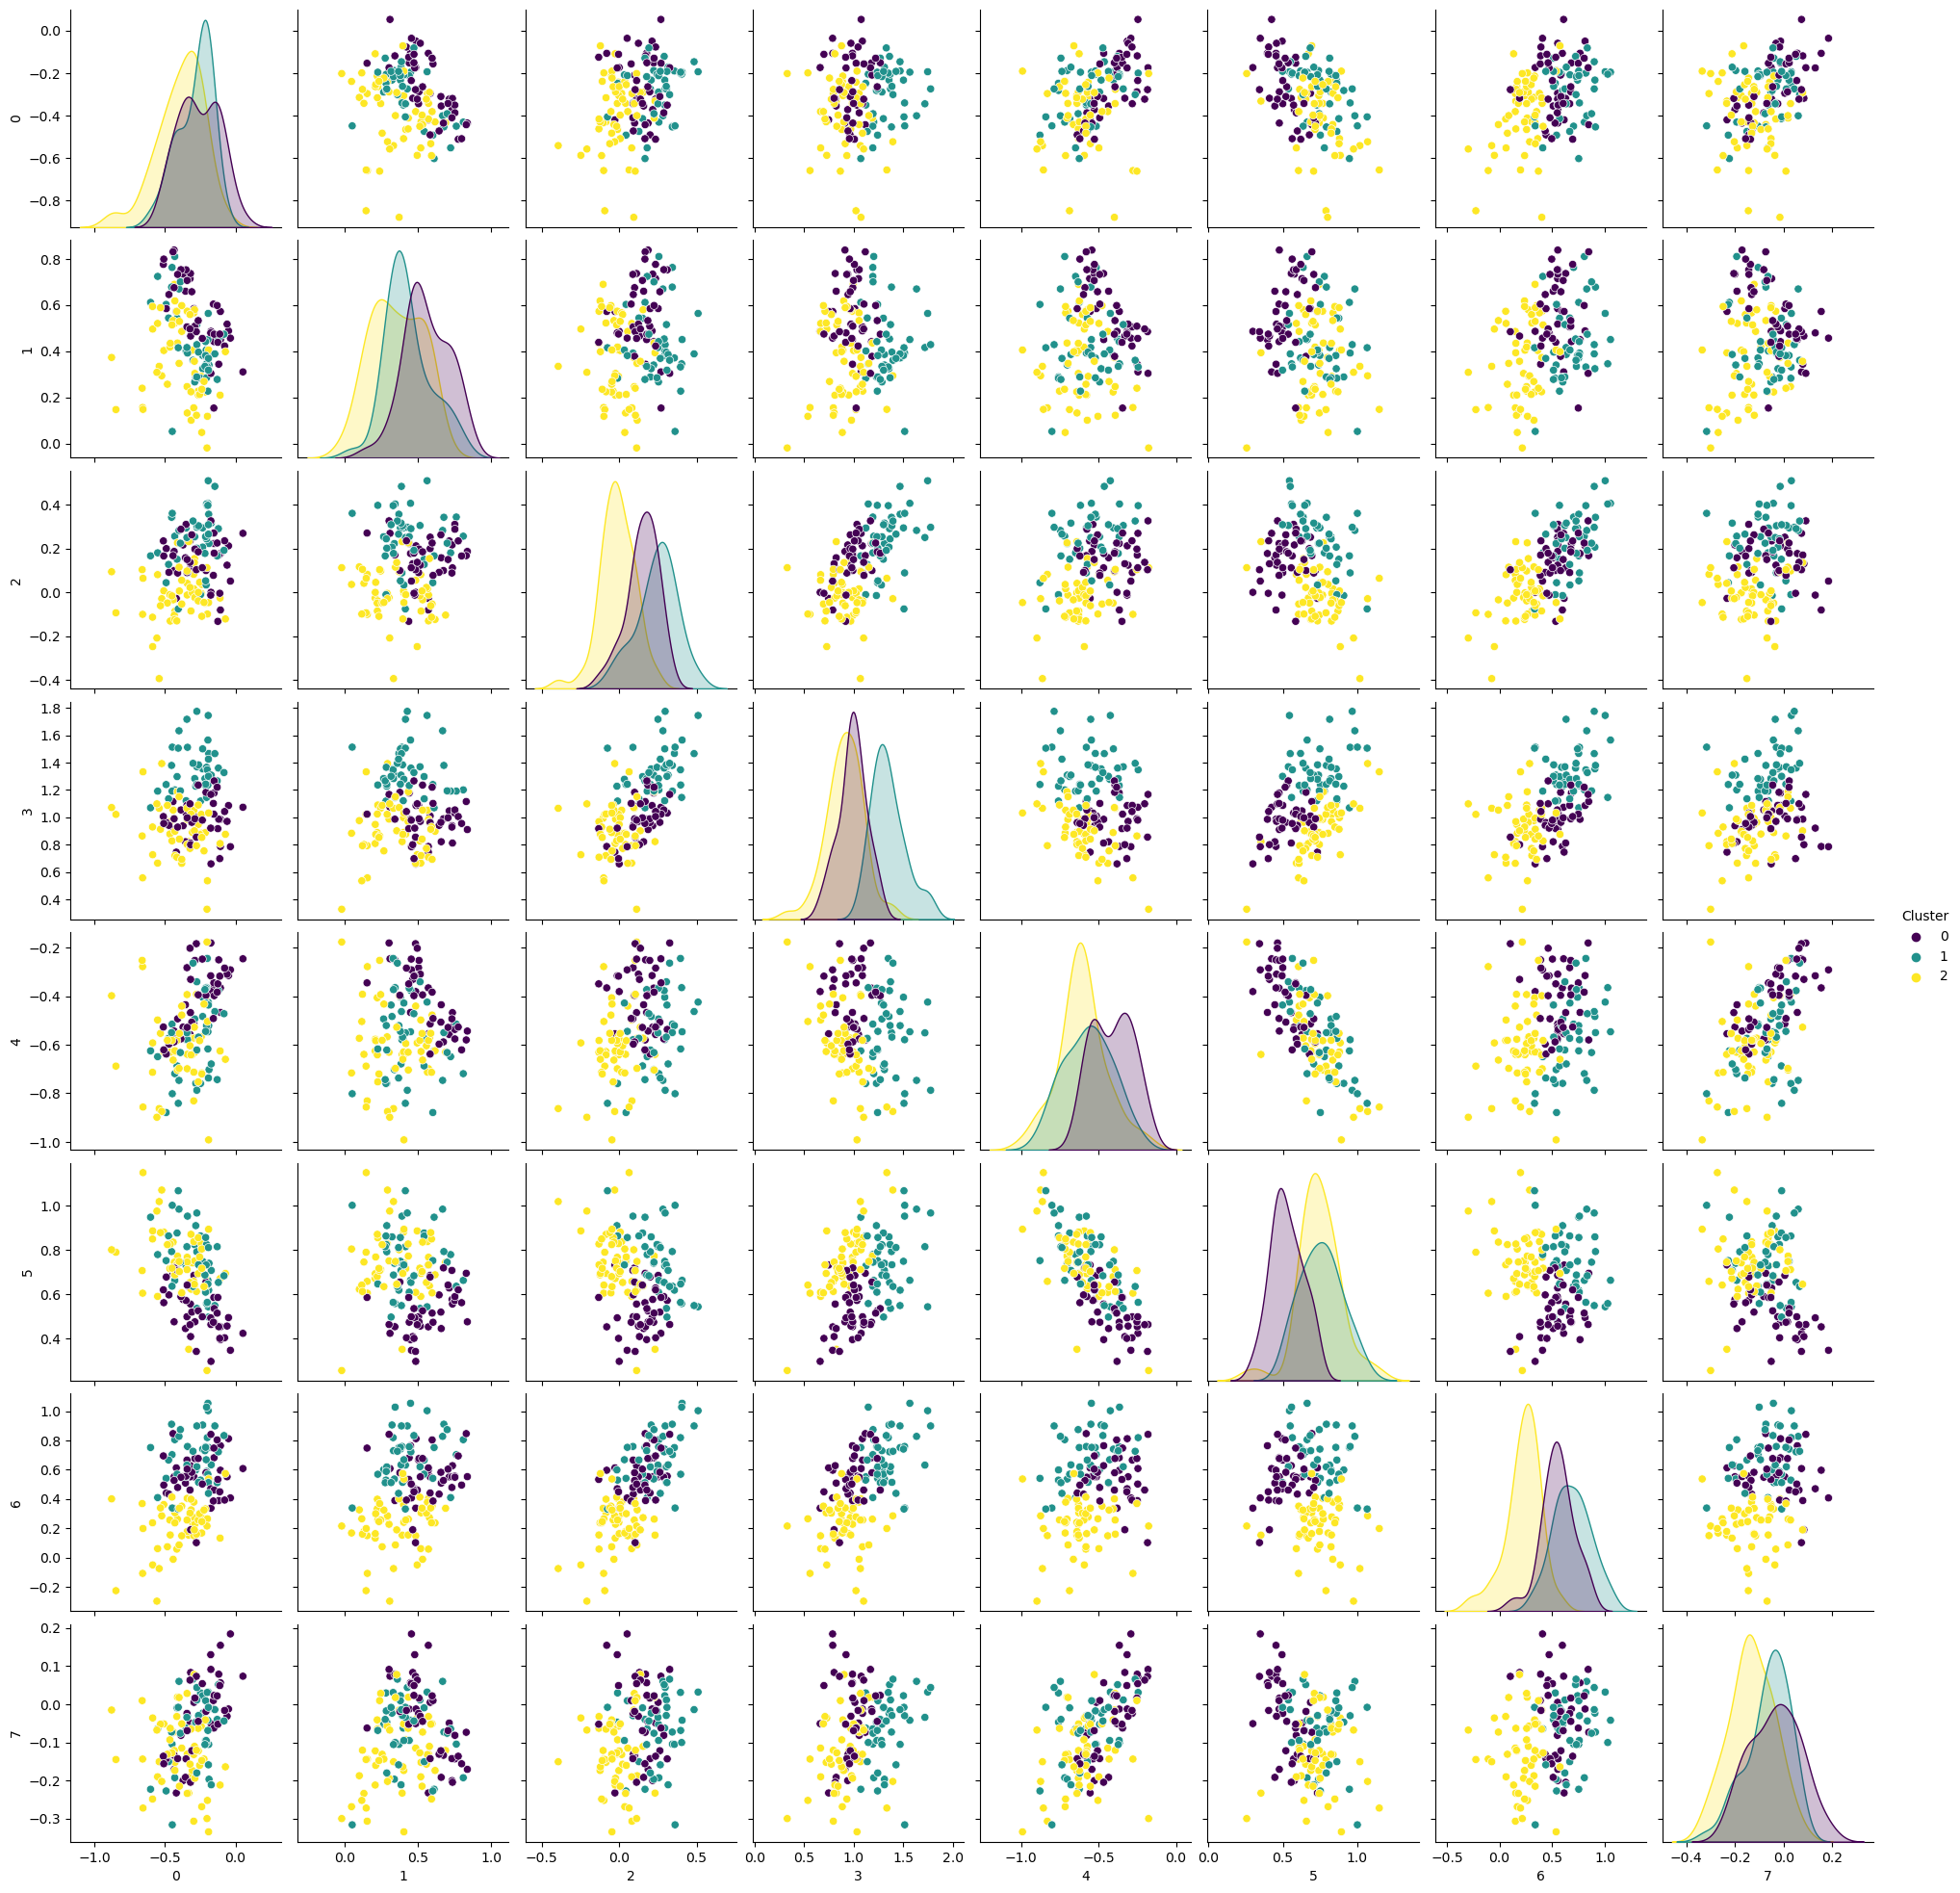

In [15]:
# Create a new DataFrame for the reduced data with cluster labels for pair plotting
rp_df = pd.DataFrame(X_train_rp)
rp_df['Cluster'] = kmeans_labels

# Use Seaborn's pairplot function to visualize the results of clustering
sns.pairplot(rp_df, hue='Cluster', palette='viridis')
plt.show()

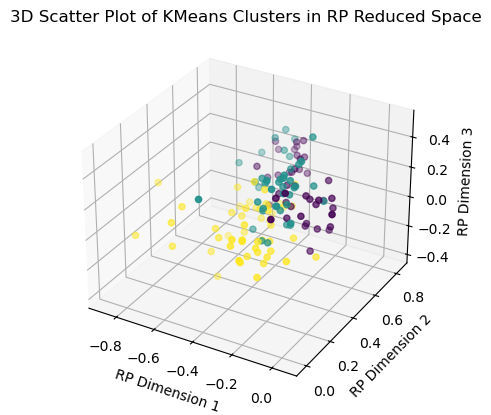

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Choose three components to plot
ax.scatter(X_train_rp[:, 0], X_train_rp[:, 1], X_train_rp[:, 2], c=kmeans_labels, cmap='viridis', marker='o')

ax.set_xlabel('RP Dimension 1')
ax.set_ylabel('RP Dimension 2')
ax.set_zlabel('RP Dimension 3')
plt.title('3D Scatter Plot of KMeans Clusters in RP Reduced Space')
plt.show()

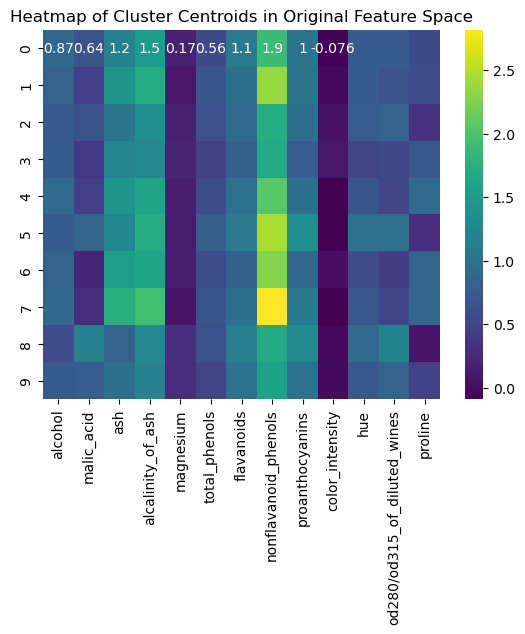

In [17]:
# Transform cluster centroids back to the original space for interpretation
original_space_centroids = centroids.dot(optimal_rp.components_) + np.mean(X_train, axis=0)

# Create a DataFrame for the heatmap
centroids_df = pd.DataFrame(original_space_centroids, columns=feature_names)

# Plot a heatmap
sns.heatmap(centroids_df, annot=True, cmap='viridis')
plt.title('Heatmap of Cluster Centroids in Original Feature Space')
plt.show()

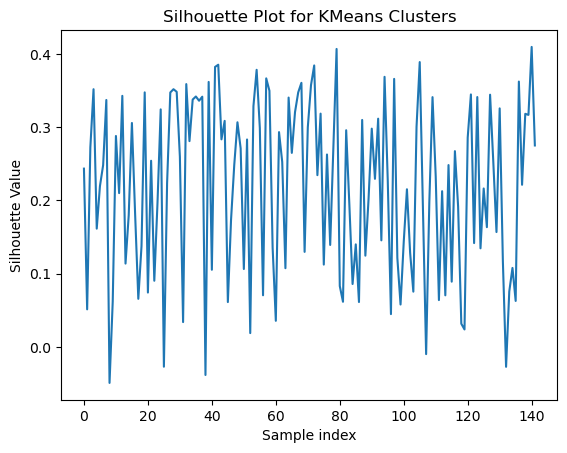

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_train_rp, kmeans_labels)

# Create a silhouette plot
plt.plot(sample_silhouette_values)
plt.title('Silhouette Plot for KMeans Clusters')
plt.xlabel('Sample index')
plt.ylabel('Silhouette Value')
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


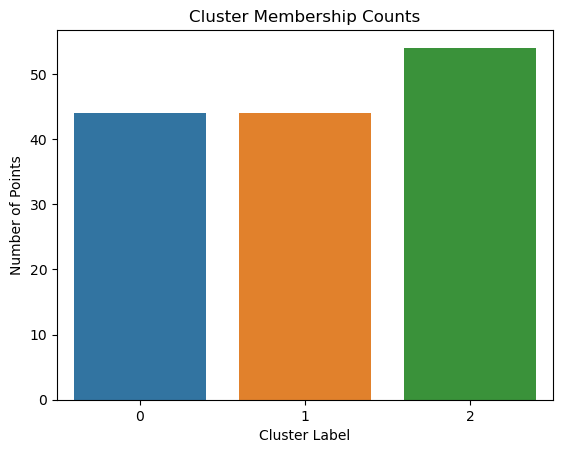

In [19]:
sns.countplot(x=kmeans_labels)
plt.title('Cluster Membership Counts')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.show()

In [20]:
silhouette_avg = silhouette_score(X_train_rp, kmeans_labels)
print(f"Average Silhouette Score: {silhouette_avg:.2f}")

Average Silhouette Score: 0.22


In [21]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz = calinski_harabasz_score(X_train_rp, kmeans_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")

Calinski-Harabasz Index: 50.13


In [22]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin = davies_bouldin_score(X_train_rp, kmeans_labels)
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")

Davies-Bouldin Index: 1.44


In [23]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity = homogeneity_score(y_train, kmeans_labels)
completeness = completeness_score(y_train, kmeans_labels)
v_measure = v_measure_score(y_train, kmeans_labels)

print(f"Homogeneity: {homogeneity:.2f}")
print(f"Completeness: {completeness:.2f}")
print(f"V-Measure: {v_measure:.2f}")

Homogeneity: 0.22
Completeness: 0.21
V-Measure: 0.21


In [24]:
from sklearn.metrics import adjusted_mutual_info_score

adjusted_mutual_info = adjusted_mutual_info_score(y_train, kmeans_labels)
print(f"Adjusted Mutual Information (AMI) Score: {adjusted_mutual_info:.2f}")

Adjusted Mutual Information (AMI) Score: 0.20


In [25]:
print(f"Sum of Squared Distances (SSE or Inertia): {sse:.2f}")

Sum of Squared Distances (SSE or Inertia): 23.08


In [26]:
unique, counts = np.unique(kmeans_labels, return_counts=True)
print(f"Cluster Size Distribution: {dict(zip(unique, counts))}")

Cluster Size Distribution: {0: 44, 1: 44, 2: 54}


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

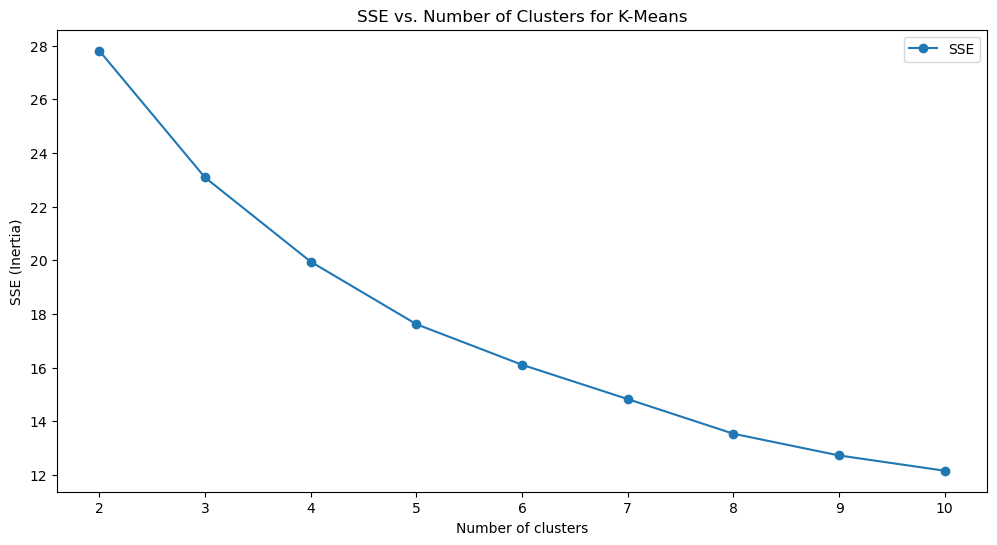

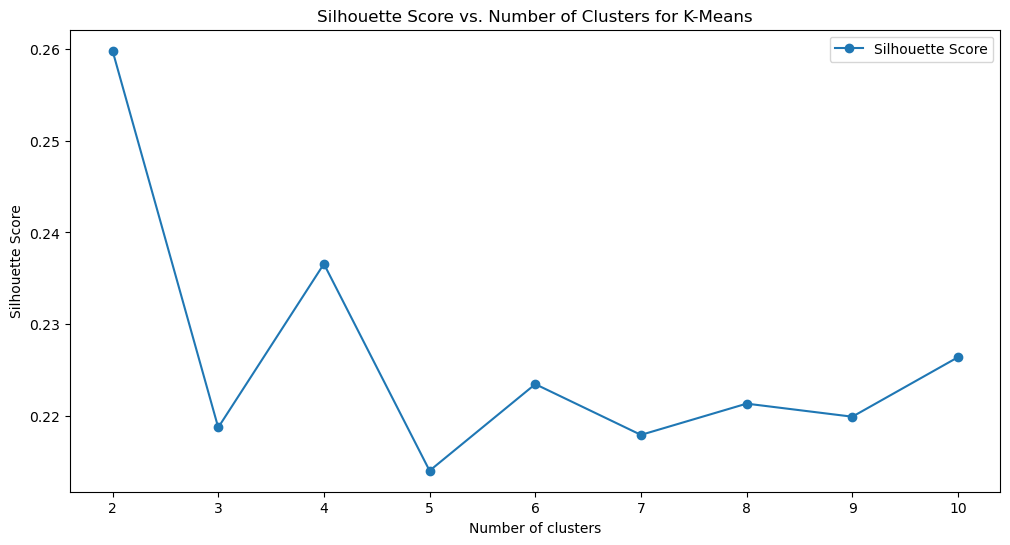

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of clusters to evaluate
n_clusters_range = range(2, 11)  # For example, from 2 to 10 clusters
inertias = []  # To store the sum of squared distances of samples to their closest cluster center
silhouette_scores = []

# Compute inertia and silhouette score for each number of clusters
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_rp)
    labels = kmeans.labels_
    
    # Append inertia
    inertias.append(kmeans.inertia_)
    
    # Compute and append silhouette score
    silhouette_avg = silhouette_score(X_train_rp, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting Inertia (SSE)
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, inertias, label='SSE', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.title('SSE vs. Number of Clusters for K-Means')
plt.legend()
plt.show()

# Plotting Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, silhouette_scores, label='Silhouette Score', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters for K-Means')
plt.legend()
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

Optimal number of clusters according to Silhouette Score: 2


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


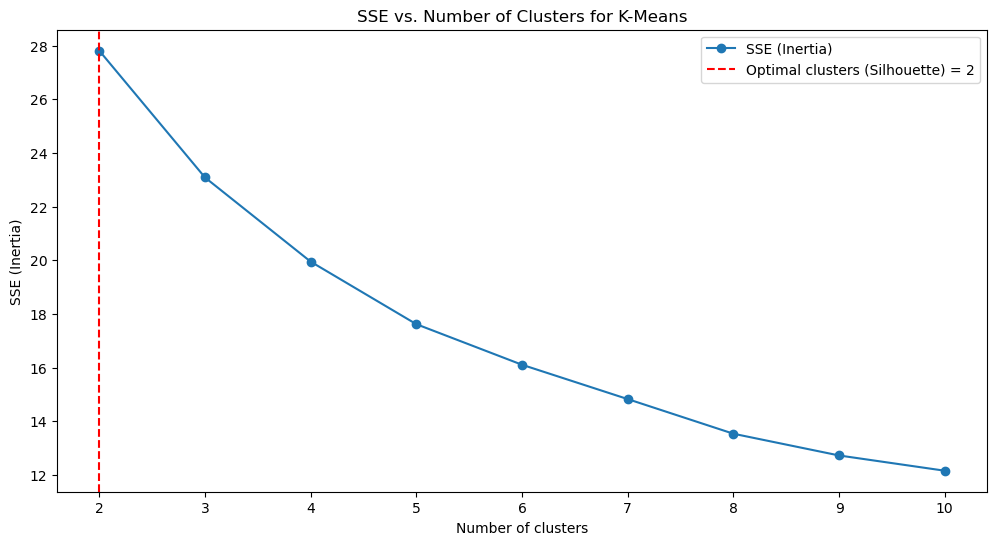

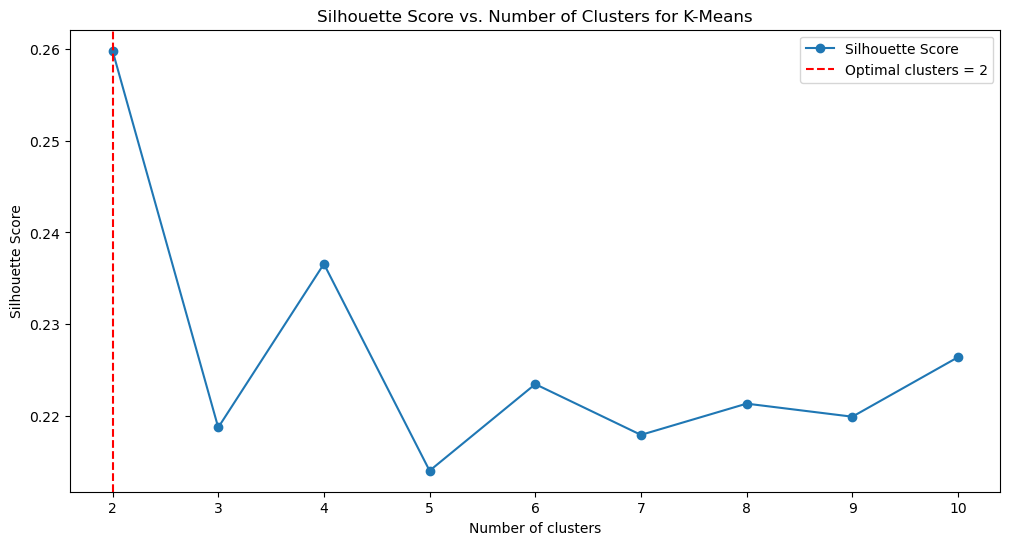

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of clusters to evaluate
n_clusters_range = range(2, 11)  # For example, from 2 to 10 clusters
inertias = []  # To store the sum of squared distances of samples to their closest cluster center
silhouette_scores = []

# Compute inertia and silhouette score for each number of clusters
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_rp)
    labels = kmeans.labels_
    
    # Append inertia
    inertias.append(kmeans.inertia_)
    
    # Compute and append silhouette score
    silhouette_avg = silhouette_score(X_train_rp, labels)
    silhouette_scores.append(silhouette_avg)

# Determine the optimal number of clusters based on silhouette score
optimal_n_clusters_silhouette = n_clusters_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters according to Silhouette Score: {optimal_n_clusters_silhouette}")

# Plotting Inertia (SSE)
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, inertias, 'o-', label='SSE (Inertia)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.title('SSE vs. Number of Clusters for K-Means')
plt.axvline(optimal_n_clusters_silhouette, linestyle='--', color='red', label=f'Optimal clusters (Silhouette) = {optimal_n_clusters_silhouette}')
plt.legend()
plt.show()

# Plotting Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, silhouette_scores, 'o-', label='Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters for K-Means')
plt.axvline(optimal_n_clusters_silhouette, linestyle='--', color='red', label=f'Optimal clusters = {optimal_n_clusters_silhouette}')
plt.legend()
plt.show()